Try the program in: https://towardsdatascience.com/variational-inference-with-normalizing-flows-on-mnist-9258bbcf8810

In [3]:
import os
from PIL import Image,ImageFont,ImageDraw

import numpy as np
# import scipy as sp
# import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np

import os
from PIL import Image,ImageFont,ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import random

## Standard libraries
import os
import math
import time
import numpy as np

## Imports for plotting

%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
# matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

In [4]:
# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


In [5]:
# 

In [6]:
from torch import Tensor
from typing import Tuple
import time

# Ref: (Mentioned in previous notebook)
class PlanarTransform(nn.Module):
    """Implementation of the invertible transformation used in planar flow:
        f(z) = z + u * h(dot(w.T, z) + b)
    See Section 4.1 in https://arxiv.org/pdf/1505.05770.pdf. 
    """
    def __init__(self, dim: int = 2):
        """Initialise weights and bias. 
        Args:
            dim: Dimensionality of the distribution to be estimated.
        """
        super().__init__()
        self.w = nn.Parameter(torch.randn(1, dim).normal_(0, 0.1))
        self.b = nn.Parameter(torch.randn(1).normal_(0, 0.1))
        self.u = nn.Parameter(torch.randn(1, dim).normal_(0, 0.1))

    def forward(self, z: Tensor) -> Tensor:
        if torch.mm(self.u, self.w.T) < -1:
            self.get_u_hat()
        return z + self.u * nn.Tanh()(torch.mm(z, self.w.T) + self.b)

    def log_det_J(self, z: Tensor) -> Tensor:
        if torch.mm(self.u, self.w.T) < -1:
            self.get_u_hat()
        a = torch.mm(z, self.w.T) + self.b
        psi = (1 - nn.Tanh()(a) ** 2) * self.w
        abs_det = (1 + torch.mm(self.u, psi.T)).abs()
        log_det = torch.log(1e-7 + abs_det)
        return log_det

    def get_u_hat(self) -> None:
        """Enforce w^T u >= -1. When using h(.) = tanh(.), this is a sufficient condition 
        for invertibility of the transformation f(z). See Appendix A.1.
        """
        wtu = torch.mm(self.u, self.w.T)
        m_wtu = -1 + torch.log(1 + torch.exp(wtu))
        self.u.data = (
            self.u + (m_wtu - wtu) * self.w / torch.norm(self.w, p=2, dim=1) ** 2
        )
      
class PlanarFlow(nn.Module):
    def __init__(self, dim: int = 2, K: int = 6):
        """Make a planar flow by stacking planar transformations in sequence.
        Args:
            dim: Dimensionality of the distribution to be estimated.
            K: Number of transformations in the flow. 
        """
        super().__init__()
        self.K = K
        self.layers = [PlanarTransform(dim) for _ in range(K)]
        self.model = nn.Sequential(*self.layers)
    def forward(self, z: Tensor) -> Tuple[Tensor, float]:
        log_det_J = 0
        for layer in self.layers:
            log_det_J += layer.log_det_J(z)
            z = layer(z)
        return z, log_det_J

class InferenceNetwork(nn.Module):
    def __init__(self, c_in=2, c_K=4, c_hidden=8): # map some data with c_in dim with c_K flows
        super().__init__()
        self.c_in = c_in
        self.c_hidden = c_hidden
        flows = []
        # for k in range(c_K):
        #   flows.append(PlanarFlow(dim=c_in, K=1))
        flows.append(PlanarFlow(dim=c_in, K=c_K))
        self.flows = nn.ModuleList(flows).to(device)
        self.prior = torch.distributions.normal.Normal( loc=0.0, scale=1.0 )

    def forward(self, x):
        ldj = 0
        z = x
        for flow in self.flows:
          z, ldj_tmp = flow(z)
          ldj = ldj + ldj_tmp
        return z, ldj
        # return self.flows(x)
      
    def sample(self, num): 
        z = self.prior.sample(sample_shape=(num,self.c_in)).to(device)
        ll = torch.distributions.Normal(torch.zeros_like(z), torch.ones_like(z)).log_prob(z).sum(-1)
        ldj = 0 ## Incorrect, this ldj should include the base probability. 
        for flow in self.flows:
          z, ldj_tmp = flow(z)
          ldj = ldj + ldj_tmp
        return z, ldj, ll

    # def generateDensity(self, x):
        

# Ref: https://github.com/ex4sperans/variational-inference-with-normalizing-flows/blob/master/utils.py
def w1_helper(z):
  return torch.sin( 2.0*np.pi/4.0 * z[:,0] )
def w2_helper(z):
  return 3*torch.exp( -0.5*( (z[:,0]-1)/0.6 )**2   )
def sigma_helper(z):
  return 1. / (1. +torch.exp(-z) )
def w3_helper(z):
  return 3*sigma_helper( (z[:,0]-1)/0.3  )

def PotentialU1(z):
  exp1 = torch.exp(  -0.5*((z[:,0]**2-2.0)/0.6)**2 )
  exp2 = torch.exp(  -0.5*((z[:,0]**2+2.0)/0.6)**2 )
  u = 0.5*( ((z[:,0]**2+z[:,1]**2)**0.5-2)/0.4 )**2-safe_log(exp1+exp2) #torch.log(exp1+exp2)
  return torch.exp( -u )

def PotentialU2(z):
  u = 0.5*( ( z[:,1] - w1_helper(z) )/0.4 )**2
  return torch.exp( -u )

def PotentialU3(z):
  exp1 = torch.exp( -0.5*( ( z[:,1] - w1_helper(z) )/0.35 )**2 )
  exp2 = torch.exp(  -0.5*( (z[:,1]-w1_helper(z)+w2_helper(z))/0.35   )**2 )
  u = -torch.log(exp1+exp2)
  return torch.exp( -u )

def PotentialU4(z):
  exp1 = torch.exp( -0.5*( ( z[:,1] - w1_helper(z) )/0.35 )**2 )
  exp2 = torch.exp(  -0.5*( (z[:,1]-w1_helper(z)+w3_helper(z))/0.4   )**2 )
  u = -torch.log(exp1+exp2)
  return torch.exp( -u )

def safe_log(z):
  return torch.log(z + 1e-7)

def getLoss(z , ldj, base_ll, LossFn=PotentialU2):
  return ( base_ll -ldj -safe_log(LossFn(z)) ).mean()
  # return (base_ll - ldj - safe_log(LossFn(z))).mean()
  # return ( -ldj - safe_log(LossFn(z))).mean()

# def compute_log_p_x(model, x_mb):
#     y_mb, log_diag_j_mb = model.forward(x_mb)
#     log_p_y_mb = (
#         torch.distributions.Normal(torch.zeros_like(y_mb), torch.ones_like(y_mb))
#         .log_prob(y_mb)
#         .sum(-1)
#     ) # Revise: change y_mb into x_mb
#     return log_p_y_mb + log_diag_j_mb

# def compute_kl(model, batch_dim=10000, energyU=PotentialU2):
#     d_mb = torch.distributions.Normal(
#         torch.zeros((batch_dim, 2)).to(device),
#         torch.ones((batch_dim, 2)).to(device),
#     )
#     y_mb = d_mb.sample()
#     x_mb, log_diag_j_mb = model(y_mb)
#     log_p_y_mb = d_mb.log_prob(y_mb).sum(-1)
#     return (
#         log_p_y_mb
#         - log_diag_j_mb
#         + energyU(x_mb)
#         + (torch.relu(x_mb.abs() - 6) ** 2).sum(-1)
#     )
    

epoch= 0  loss= tensor(3.4436, device='cuda:0', grad_fn=<MeanBackward0>) time= 0.6515393257141113
epoch= 500  loss= tensor(2.4033, device='cuda:0', grad_fn=<MeanBackward0>) time= 3.8090689182281494
epoch= 1000  loss= tensor(3.3008, device='cuda:0', grad_fn=<MeanBackward0>) time= 7.067636966705322
epoch= 1500  loss= tensor(3.0472, device='cuda:0', grad_fn=<MeanBackward0>) time= 10.125559568405151
epoch= 2000  loss= tensor(2.2218, device='cuda:0', grad_fn=<MeanBackward0>) time= 13.149754762649536
epoch= 2500  loss= tensor(1.4691, device='cuda:0', grad_fn=<MeanBackward0>) time= 16.116453170776367
epoch= 3000  loss= tensor(1.6101, device='cuda:0', grad_fn=<MeanBackward0>) time= 19.06557822227478
epoch= 3500  loss= tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>) time= 22.03126549720764
epoch= 4000  loss= tensor(0.7769, device='cuda:0', grad_fn=<MeanBackward0>) time= 25.072535037994385
epoch= 4500  loss= tensor(0.7191, device='cuda:0', grad_fn=<MeanBackward0>) time= 28.1216731071472

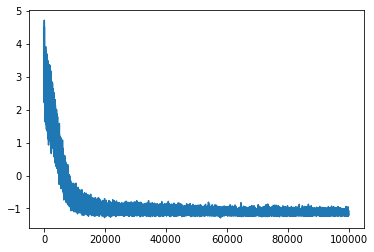

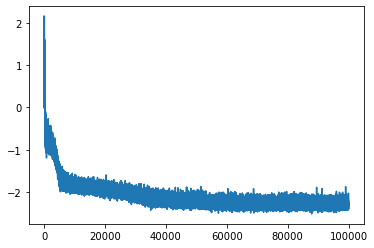

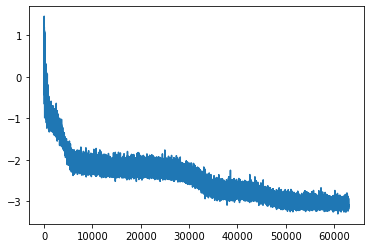

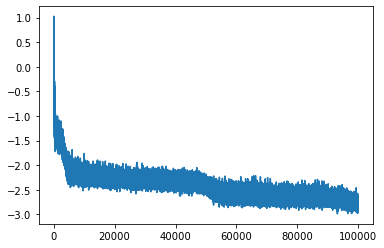

In [7]:
# Ref: https://github.com/nicola-decao/BNAF/blob/master/toy2d.py

import os
import json
import argparse
import pprint
import datetime
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils import data
from tqdm import trange


def showResult(net,id=1, point_end = 300):
  fig2 = plt.figure(id)
  with torch.no_grad():
    d_out, d_ldj_out = net.sample(point_end)
    d_out = d_out.to('cpu').numpy()
    plt.scatter( d_out[:,0] , d_out[:,1] )
    plt.axis([-4, 4, -4, 4])
    plt.figure(figsize=(5, 5))


max_epoch = 100000
point_each_itr = 100

LossFn_list = [PotentialU1,PotentialU2,PotentialU3,PotentialU4]
# LossFn_list = [PotentialU1]

loss_list_list = []
for loss_i, loss_fn in enumerate( LossFn_list ):
    # print ( "Running Loss_fn=",loss_i )
    assert( loss_fn is not None )

    net = InferenceNetwork( c_in=2, c_K=8, c_hidden=8 )
    # optimizer = optim.Adam(net.parameters(), lr=1e-3)
    optimizer = optim.RMSprop(net.parameters(), lr=5e-5, momentum=0.9)

    loss_list = []
    seconds_st = time.time()
    for epoch in range(max_epoch):
        optimizer.zero_grad()
        d_out, d_ldj_out, base_ll = net.sample(point_each_itr)
        # print ( d_out )
        loss = getLoss(d_out, d_ldj_out, base_ll, LossFn=loss_fn)
        # print ( "epoch" , epoch ,d_out, d_ldj_out, loss )
        loss_list.append(loss.cpu().detach().numpy())

        loss.backward()
        optimizer.step()

        if ( epoch % 1000 == 0 ):
            print ( "epoch=",epoch , " loss=",loss, "time=", time.time()-seconds_st )
        if ( epoch % 50000 == 0 ):
            torch.save(net.state_dict(), "./model_u2_k8_"+str(epoch)+"auto_save"+str( (int)(time.time())%1000 ) )
    
    print ( "time for train:", time.time()-seconds_st )
    print ( "epoch=", epoch, " loss=",loss )  # print ( d_out[:,0] )
    fig1 = plt.figure(loss_i*3+1)
    plt.plot(range(len(loss_list)) , loss_list)
    # showResult(net , loss_i*3+2 )
    # plot_density2d(model=net, id=loss_i*3+3, limit=4.0, step=0.01)
    torch.save(net.state_dict(), "./model_u2_k8_1028_"+str(max_epoch)+"_lossfn"+str(loss_i)) #+"_time_"+str( (int)(time.time())%10000 ))
    # loss_list_list.append(loss_list)


Running Loss_fn= 0
(1440000, 2)
1440000
1001107
1.0
Running Loss_fn= 1
(1440000, 2)
1440000
421376
1.0
Running Loss_fn= 2
(1440000, 2)
1440000


/tmp/ipykernel_3098/2778380957.py:60: RuntimeWarning: invalid value encountered in true_divide
  grid_fig = (grid_fig / np.max(grid_fig)).T


0
nan
Running Loss_fn= 3
(1440000, 2)
1440000
299049
1.0


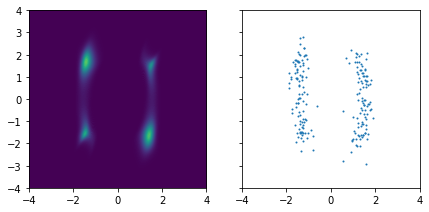

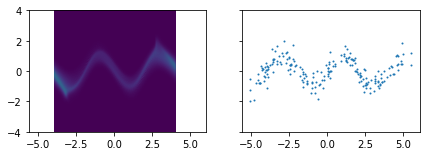

/home/armlab/miniconda3/envs/torchtime/lib/python3.9/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/armlab/miniconda3/envs/torchtime/lib/python3.9/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


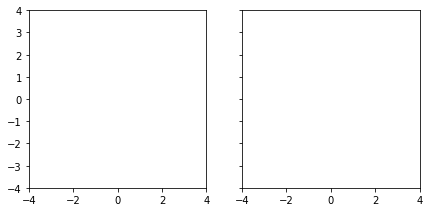

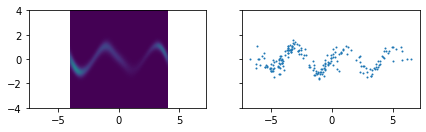

In [8]:

def generateGrid( limit=4, step=0.01 ):
    return [
            [a, b]
            for a in np.arange(-limit, limit, step)
            for b in np.arange(-limit, limit, step)
        ]
def plot_density2d(model, ax=None, id=1, limit=4, step=0.01):
    grid = []
    grid.append( generateGrid(6,0.01) )
    # grid.append( generateGrid(1.0,0.003) )
    grid = np.concatenate(grid , axis=0)
    print ( np.array(grid).shape )
    grid = torch.Tensor(grid)
    # grid = torch.cat( [grid,grid_n1] , axis=0 )
    
    batch_size = 500
    grid_dataset = torch.utils.data.TensorDataset(grid.to(device))
    grid_data_loader = torch.utils.data.DataLoader(
        grid_dataset, batch_size=batch_size, shuffle=False
    )

    y_mb = []
    y_mb_ldj = []
    # x_mb = []
    prob = []
    for x_mb_tmp, in grid_data_loader:
        if ( len(x_mb_tmp) < batch_size ):
            continue
        z, ldj = model(x_mb_tmp)
        # x_mb.append( x_mb_tmp.detach().cpu().numpy() )
        prob.append( torch.distributions.Normal(torch.zeros_like(x_mb_tmp), torch.ones_like(x_mb_tmp)).log_prob(x_mb_tmp).sum(-1).detach().cpu().numpy() )
        y_mb.append( z.detach().cpu().numpy() )
        y_mb_ldj.append( ldj.detach().cpu().numpy() )
    y_mb = np.concatenate(y_mb , axis=0)
    # print ( np.array(y_mb_ldj).shape )
    y_mb_ldj = np.concatenate(y_mb_ldj , axis=0)
    y_mb_ldj = np.concatenate(y_mb_ldj , axis=0)
    # print ( y_mb.shape , y_mb_ldj.shape )
    # x_mb = np.concatenate(x_mb , axis=0)
    # assert( x_mb.shape == y_mb.shape )
    
    prob = np.concatenate(prob , axis=0)
    assert( prob.shape == y_mb_ldj.shape )

    print ( len(prob) )
    # ax.scatter( y_mb[:,0] , y_mb[:,1] , s=1.0)

    count = 0
    grid_fig = np.zeros( ((int)(2*limit/step)+1,(int)(2*limit/step)+1) )
    grid_fig_count = np.zeros( ((int)(2*limit/step)+1,(int)(2*limit/step)+1) )
    for i in range( len(prob) ):
        if ( y_mb[i,0] > -limit and y_mb[i,0] < limit and y_mb[i,1] > -limit and y_mb[i,1] < limit ):
            x = (int)((y_mb[i,0]+limit)/step)
            y = (int)((y_mb[i,1]+limit)/step)
            grid_fig[ x , y ] += np.exp(prob[i]-y_mb_ldj[i])
            grid_fig_count[ x,y ] += 1
            count += 1
    
    # grid_fig = np.exp( grid_fig )
    grid_fig = (grid_fig / np.max(grid_fig)).T
    print ( count )
    print ( np.max(grid_fig) )
    if ( ax == None ):
        plt.figure(id,figsize=(5, 5)) # figsize=(7, 5)
        plt.imshow(grid_fig, extent=(-limit, limit, -limit, limit))
        plt.axis([-4, 4, -4, 4])    
    else:
        ax.imshow(grid_fig , extent=(-limit, limit, -limit, limit) )
        # ax.axis([-4, 4, -4, 4])

# LossFn_list = [PotentialU1,PotentialU2,PotentialU3,PotentialU4]
point_end = 200
# print ( max_epoch)
for loss_i, loss_fn in enumerate(LossFn_list):
    print ( "Running Loss_fn=",loss_i )
    net = InferenceNetwork( c_in=2, c_K=8, c_hidden=8 )
    net.load_state_dict(torch.load("./model_u2_k8_1028_"+str(max_epoch)+"_lossfn"+str(loss_i)))

    f, (ax1, ax2) = plt.subplots(nrows= 1, ncols= 2, sharex=True, sharey=True , figsize = [7, 7] )
    plot_density2d(net, ax=ax1, id=1, limit=4, step=0.01)
    with torch.no_grad():
        d_out, d_ldj_out,d_ldj_base = net.sample(point_end)
        d_out = d_out.to('cpu').numpy()
        ax2.scatter( d_out[:,0] , d_out[:,1] , s=1.0)
        ax2.set_aspect('equal')
    # ax3.plot(loss_list_list[loss_i])
    


